In [1]:
import sys
sys.version

'3.6.4 | packaged by conda-forge | (default, Dec 24 2017, 10:11:43) [MSC v.1900 64 bit (AMD64)]'

In [2]:
import attr

In [ ]:
#import tcod, color
#import tcod.console as console
from ipykernel.eventloops import register_integration
import attr
from gameclock import GameClock
from MapChunk import PolygonMap
import random as rand
import numpy as np

import IPython.core
shell = IPython.core.getipython.get_ipython()


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


matplotlib.style.use('seaborn-talk')
plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['figure.dpi'] = 120

%load_ext autoreload
%autoreload 2


# Simple Interactive Application WIth Canvas

python-tdl wants one to call tdl.init() to set up the root console.

For event handling the python-tdl way is to subclass tdl.App. The action happens
in `tdl.App.run_once`, but the time tracking is simple and would probably
benefit from the inclusion of GameClock.


In [ ]:
%run ipy_app.py
app = InteractiveApp(shell.kernel)
app.init_root(width=80, height=80, show_credits=False)
app.run()

We can update and draw to the application by manipulating the canvas attribute,
which is an off-screen representation that is periodically blitted onto the root
console.

In [58]:
app.canvas.clear()

In [59]:
app.canvas.draw_rect(0, 1, 10, 10, ".", fg=tcod.light_amber)
app.canvas.draw_rect(0, 0, 15, 3, None, bg=tcod.white)
app.canvas.draw_str(10, 10, "Help me!")
app.canvas.draw_str(10, 11, "Another line.")
app.canvas.draw_frame(20,0, 10, 10, None, fg=tcod.white, bg=tcod.grey)

ERROR! Session/line number was not unique in database. History logging moved to new session 784


In [12]:
app.canvas.get_char(10,10)

(72, (255, 255, 255), (0, 0, 0))

## Heightmaps

In [2]:
h2 = tcod.heightmap_new(80, 80)
h2[:] = 0

In [3]:
h2

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [4]:
tcod.heightmap_add_hill(h2, 20, 20, 5, 5)

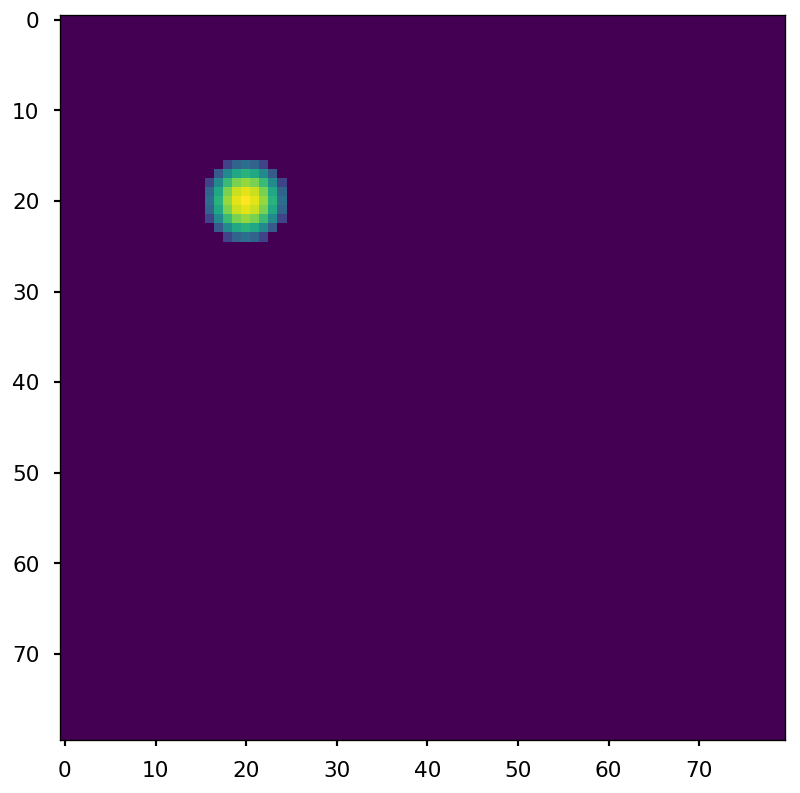

In [5]:
plt.imshow(h2)

In [39]:
tcod.heightmap_rain_erosion(h2, 100, 0.5, 0.1)

In [41]:
plt.imshow(h2)

In [42]:
from tdl.noise import Noise

n = Noise()

In [43]:
n.get_point(2.3,2.4,0)

0.36815790832042694

In [76]:
hn = tcod.heightmap_new(80, 80)
hn[:] = 0.0
hn

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [ ]:
for i in range(rand.randint(100, 1000)):
    x, y = rand.random()*80, rand.random()*80
    radius = rand.random()*20
    height = rand.random()*10
    print("({}, {}) = {}, {}".format(x, y, radius, height))
    tcod.heightmap_add_hill(hn, x, y, radius, height)

In [82]:
plt.imshow(hn)


In [79]:
tcod.heightmap_rain_erosion(hn, 80*80, 0.05, 0.01)

In [80]:
np.shape(hn)

(80, 80)

In [81]:
min, max = tcod.heightmap_get_minmax(hn)
width, height = np.shape(hn)
for i in range(width):
    for j in range(height):
        color = tcod.color_lerp(tcod.dark_blue, tcod.white, hn[i, j]/max)
        app.canvas.draw_char(i, j, ' ', fg=tcod.white, bg=color)

## Integrating PolygonMap with InteractiveApp

In [30]:
map = PolygonMap(feature_cnt=500, width=100.0, height=100.0)

In [31]:
f = map[0,0]
f

TerrainFeatures(idx=271, parent=<MapChunk.PolygonMap object at 0x0000017D3B587588>, elevation=0.0, water=False, ocean=False, precipitation=0.0, temperature=0.0, color=0.0)

In [32]:
f.__setattr__('elevation', 10)
f.__getattribute__('elevation')

10

In [33]:
elev = map.terrain(0,0,'elevation')
elev

10

In [34]:
hm = map.terrain_to_hm('elevation')
(hm[0,0], hm[0,1], hm[0,9])

(10.0, 10.0, 0.0)

In [35]:
import random as rand

map = PolygonMap(feature_cnt=int((80*60)/10), width=80, height=60)
hn = map.terrain_to_hm('elevation')

for i in range(rand.randint(20, 100)):
    x, y = rand.randint(0, 80), rand.randint(0, 60)
    radius = rand.randint(0, 20)
    height = rand.randint(0, 10)
    hn.add_hill(x, y, radius, height)

map.hm_to_terrain(hn, 'elevation')

In [36]:
(hn[0,4], map[0,4])

(10.263359069824219,
 TerrainFeatures(idx=387, parent=<MapChunk.PolygonMap object at 0x0000017D3CBE2470>, elevation=9.4771728515625, water=False, ocean=False, precipitation=0.0, temperature=0.0, color=0.0))

Game logic updates:

1. Update world state.
2. Update agents.
3. Update canvas.
4. Draw (this is InteractiveApp.my_update)



### Canvas Update

A naive, slow canvas update:

In [37]:
def canvas_update(canvas):
    canvas.clear()
    canvas.draw_terrain()
    canvas.draw_features() # Features are things like walls, trees
    canvas.draw_agents()

# Sample App Using Polygon Maps

In [38]:
import tdl, tcod
from gameclock import GameClock
from MapChunk import PolygonMap, gEntity
from ipy_app import WorldState, GameApp
import numpy as np

In [0]:
state = WorldState(80,40)
app = GameApp(shell.kernel)
app.init_root(state, width=80, height=40, show_credits=False)
app.run()

Generate a very basic elevation map.

In [39]:
import random as rand
hn = state.wmap.terrain_to_hm('elevation')

for i in range(rand.randint(20, 100)):
    x, y = rand.randint(0, 80), rand.randint(0, 60)
    radius = rand.randint(0, 20)
    height = rand.randint(0, 10)
    hn.add_hill(x, y, radius, height)

state.wmap.hm_to_terrain(hn, 'elevation')

ERROR! Session/line number was not unique in database. History logging moved to new session 652


In [40]:
state.draw_terrain()

In [41]:
player = gEntity(eclass='actor', name='Player')
orc = gEntity(eclass='actor', name='Orc')
player.pos = np.array((5,5))
player.glyph = '@'
orc.glyph = 'o'
orc.pos = np.array((20, 20))
orc.color = tcod.black

state.actors = {}
state.actors[player._id] = player
state.actors[orc._id] = orc

AttributeError: 'gEntity' object has no attribute '_id'

In [11]:
orc._id

0

In [12]:
state.draw_actors()

In [13]:
orc.move(1, 0)
state.draw_actors()

ValueError: operands could not be broadcast together with shapes (2,) (3,) (2,) 

Now animate!

In [145]:
def move_me(actor):
    dx = rand.choice([1, 0, -1])
    dy = rand.choice([1, 0, -1])
    actor.move(dx, dy)

def move_actors(dt):
    for _, actor in state.actors.items():
        move_me(actor)
    state.draw_actors()

In [146]:
app.clock.schedule_interval(move_actors, 1.0)

In [147]:
app.clock.schedules

[]

In [3]:
import attr

In [4]:
attr.__version__

'16.3.0'

In [1]:
import esper